In [33]:
import geopandas as gpd
import osmium as osm
import shapely as shp

import pandas as pd

import numpy as np

import pathlib

In [34]:
class LessDataOSMHandler(osm.SimpleHandler):
    def __init__(self, category_whitelist):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []
        self.tag_list = []
        
        self.category_whitelist = category_whitelist
        
        self.wkbfab = osm.geom.WKBFactory()
        
        self.shapely_location = 0
        
        self.categories_of_osm_element = []
        
    def tag_inventory(self, elem, elem_type):
        self.tag_list = []
        for tag in elem.tags:
            self.tag_list.append((tag.k, tag.v))
        
        self.osm_data.append([elem_type,
                            self.shapely_location,
                            np.asarray(self.tag_list, dtype=str),
                            np.asarray(self.categories_of_osm_element, dtype=np.uint16)])
            
    
    def node(self, n):   
        self.categories_of_osm_element = []
        
        # check if the osm_element applies to a category
        for category in self.category_whitelist:
            name = category[0]
            whitelist= category[1]
            
            if n.tags.get(whitelist[0]): #== whitelist[1]:
                self.categories_of_osm_element.append(name)
        
        if self.categories_of_osm_element:
            self.shapely_location = shp.Point((n.location.x, n.location.y))
            self.tag_inventory(n, "node")
        
        del n
    
    def area(self, a): 
        self.categories_of_osm_element = []
            
          # check if the osm_element applies to a category
        for category in self.category_whitelist:
            name = category[0]
            whitelist= category[1]
            
            if a.tags.get(whitelist[0]): #== whitelist[1]:
                self.categories_of_osm_element.append(name)
                
        if self.categories_of_osm_element:
            # create location/multipolygon
            wkbshape = self.wkbfab.create_multipolygon(a)
            self.shapely_location = shp.wkb.loads(wkbshape, hex=True)
            
            if a.from_way:
                self.tag_inventory(a, "area-way")
            else:
                self.tag_inventory(a, "area-relation")

In [35]:
# defien a whitelist
category_1_whitelist = [1, ("building", "*")]
category_2_whitelist = [2, ("landuse", "forest")]
category_3_whitelist = [3, ("natural", "water")]
category_4_whitelist = [4, ("type", "multipolygon")]
category_5_whitelist = [5, ("building", "false")]
category_6_whitelist = [6, ("water", "river")]
category_7_whitelist = [6, ("shop", "*")]

category_list = [category_1_whitelist, category_2_whitelist, 
                 category_3_whitelist, category_4_whitelist, 
                 category_5_whitelist, category_6_whitelist]

In [36]:
osmhandler = LessDataOSMHandler(category_list)
# scan the input file and fills the handler list accordingly
osmhandler.apply_file("../data/andorra-latest.osm.pbf", locations=True)

In [37]:
# transform the list into a pandas DataFrame
data_colnames = ['osm_type', 'geometry', 'tags', 'categories']
df_osm = gpd.GeoDataFrame(osmhandler.osm_data, columns=data_colnames)
# df_osm = tag_genome.sort_values(by=['type', 'id', 'ts'])

In [38]:
df_osm.tail(5)

,osm_type,geometry,tags,categories
9540,area-way,"MULTIPOLYGON (((1.66986 42.59227, 1.66997 42.5...","[[building, yes]]","[1, 5]"
9541,area-way,"MULTIPOLYGON (((1.52579 42.56516, 1.52596 42.5...","[[building, yes]]","[1, 5]"
9542,area-way,"MULTIPOLYGON (((1.52500 42.56563, 1.52506 42.5...","[[building, yes]]","[1, 5]"
9543,area-way,"MULTIPOLYGON (((1.52448 42.56562, 1.52451 42.5...","[[building, yes]]","[1, 5]"
9544,area-way,"MULTIPOLYGON (((1.49445 42.49135, 1.49451 42.4...","[[building, yes]]","[1, 5]"


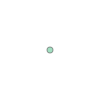

In [41]:
df_osm.iloc[0]["geometry"]

In [24]:
len(df_osm)

9545

## Test functionality
removes nodes from areas when tehy have same category

In [25]:
from __future__ import annotations

from typing import TYPE_CHECKING

"""
This file is used, to name the columns in the Dataframe.
"""

# Dataframe column(CL) names
# ----------------------------
CL_OSM_TYPE: Final = "osm_type"
CL_TAGS: Final = "tags"
CL_CATEGORY: Final = "category"
CL_GEOMETRY: Final = "geometry"
CL_TRAFFIC_CELL_NAME: Final = "traffic_cell_name"
CL_OSM_ELEMENT_NAME: Final = "element_name"
CL_AREA_WITHOUT_FLOORS: Final = "area_of_osm_element"
CL_AREA_WITH_FLOORS: Final = "area_of_osm_element_with_floors"
CL_NUMBER_OF_FLOORS: Final = "number_of_floors"

# Misc
# -----
STANDARD_OSM_ELEMENT_NAME: Final = "missing"
DONT_CARE_SYMBOL: Final = "*"

# Name of osm elements
# ---------------------
NODE_NAME: Final = "node"
AREA_WAY_NAME: Final = "area-way"
AREA_RELATION_NAME: Final = "area-relation"


In [26]:
type(df_osm)

geopandas.geodataframe.GeoDataFrame

In [27]:
area_df: GeoDataFrame = df_osm.loc[(df_osm[CL_OSM_TYPE] == AREA_WAY_NAME) | (df_osm[CL_OSM_TYPE] == AREA_RELATION_NAME)]
node_df: GeoDataFrame = df_osm.loc[(df_osm[CL_OSM_TYPE] == NODE_NAME)]

In [28]:
type(node_df.head())

geopandas.geodataframe.GeoDataFrame

In [29]:
area_df.contains(node_df[CL_GEOMETRY].iloc[0])

1149    False
1150    False
1151    False
1152    False
1153    False
        ...  
9540    False
9541    False
9542    False
9543    False
9544    False
Length: 8396, dtype: bool

In [32]:
idx: int
node_row: GeoSeries
for idx_node, node_row in node_df.iterrows():
    # This should return a GeoSeries which consists of bool values, true when the matching up row
    # in the dataframe contains the node otherwise false.
    found_areas_bool: GeoSeries = area_df[CL_GEOMETRY].within(node_row[CL_GEOMETRY]) #TODO: This could be wrong if yes use contains() instead

    # iterate over them and check their categories
    found_series: GeoSeries
    # The iloc takes in our geoseries which consists of boolean values and returns all entries
    # in the dataframe which row number is true
    for i, found_series in area_df.loc[found_areas_bool].iterrows():
        # This checks if the category name of the found_area is the same as the node ones
        # If it has the same category we delete it.
        print(len(area_df.loc[found_areas_bool]))
        if found_series[CL_CATEGORY].item() == node_row[CL_CATEGORY].item():
            # delete the node
            print("yes")
            df_osm.drop(idx_node)
            break

In [19]:
len(df_osm)

9545

In [14]:
df_osm.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9545 entries, 0 to 9544
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   osm_type    9545 non-null   object  
 1   geometry    9545 non-null   geometry
 2   tags        9545 non-null   object  
 3   categories  9545 non-null   object  
dtypes: geometry(1), object(3)
memory usage: 298.4+ KB


Osmhandler has the following attributes:
- osm_type_list
- ntags_list
- tag_list_finish
- category_list

## Backup Handler

In [7]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []
        self.coords = 0
        self.tag_list = []
        
    def tag_inventory(self, elem, elem_type):
        self.tag_list = []
        for tag in elem.tags:
            self.tag_list.append((tag.k, tag.v))
        
        if (elem_type == "node"):
            self.osm_data.append([elem_type, 
                                   self.coords,
                                   len(self.tag_list),
                                   self.tag_list])
        elif (elem_type == "way"):
            self.osm_data.append([elem_type, 
                                   0,
                                   len(self.tag_list),
                                   self.tag_list])
        else:
            self.osm_data.append([elem_type, 
                                  self.coords,
                                  len(self.tag_list),
                                  self.tag_list])
            
    
    def node(self, n):    
        self.coords = shp.Point((n.location.x, n.location.y))
        self.tag_inventory(n, "node")
        
        del n
        
        
    def way(self, w):
        test = []
        for i in range(len(w.nodes)):
            test.append((w.nodes[i].location.x, w.nodes[i].location.y))
        
        # this only works if we have more than 4 coordinates if not then throw this data entry away
        if (4 <= len(test)):
            self.coords = shp.Polygon(test.copy())
            self.tag_inventory(w, "way")
        
        # if you dont do this the libary sometimes, throws erros, maybe only jupyter issues needs furtehr testing
        del w
        del test

    # its really hard to get the location out of relations
    def relation(self, r):   
        self.tag_inventory(r, "relation")
        
        del r

## Backup Handler 2

In [9]:
class LessDataOSMHandler(osm.SimpleHandler):
    def __init__(self, category_whitelist):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []
        self.tag_list = []
        
        self.category_whitelist = category_whitelist
        
        self.wkbfab = osm.geom.WKBFactory()
        
        self.shapely_location = 0
        
        self.categories_of_osm_element = []
        
    def tag_inventory(self, elem, elem_type):
        self.tag_list = []
        for tag in elem.tags:
            self.tag_list.append((tag.k, tag.v))
        
        self.osm_data.append([elem_type,
                            #self.shapely_location,
                            len(self.tag_list),
                            np.asarray(self.tag_list, dtype=str),
                            np.asarray(self.categories_of_osm_element, dtype=np.uint16)])
            
    
    def node(self, n):   
        self.categories_of_osm_element = []
        
        # check if the osm_element applies to a category
        for category in self.category_whitelist:
            name = category[0]
            whitelist= category[1]
            
            if n.tags.get(whitelist[0]): #== whitelist[1]:
                self.categories_of_osm_element.append(name)
        
        if self.categories_of_osm_element:
            self.shapely_location = shp.Point((n.location.x, n.location.y))
            self.tag_inventory(n, "node")
        
        del n

    def way(self, w):
        self.categories_of_osm_element = []
            
         # check if the osm_element applies to a category
        for category in self.category_whitelist:
            name = category[0]
            whitelist= category[1]
            
            if w.tags.get(whitelist[0]) == whitelist[1]:
                    self.categories_of_osm_element.append(name)
        
        if self.categories_of_osm_element:
            self.tag_inventory(w, "way")

    # its really hard to get the location out of relations
    def relation(self, r):   
        self.categories_of_osm_element = []
            
          # check if the osm_element applies to a category
        for category in self.category_whitelist:
            name = category[0]
            whitelist= category[1]
            
            if r.tags.get(whitelist[0]) == whitelist[1]:
                    self.categories_of_osm_element.append(name)
                
        if self.categories_of_osm_element:   
            self.tag_inventory(r, "relation")